In [53]:
!pip3 install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


if gym.__version__ < '0.26':
    env = gym.make('CartPole-v1', new_step_api=True, render_mode='single_rgb_array').unwrapped
else:
    env = gym.make('CartPole-v1', render_mode='rgb_array').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Question 1
#In this section we are initializing the key terms that will be used for the rest of the RL algorithm "state, action, next_state & reward"
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
    # This class will help determine the next action which is one of the fundamental processes in RL algorithm. The next action taken by the cart-pole
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


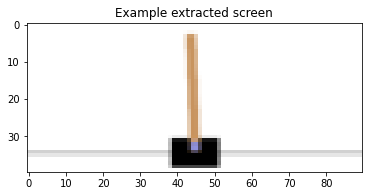

In [ ]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render().transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n
# In this section we train the DQN to update its policy with every trained state, The policy and target are specified.
policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(1)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # In this section we are specifying the state batch which contains multiple states as well as the action and reward batch accordingly that will be used in our training.         
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # In this section we use the policy that we so far have trained to gain in order to determine and call our next action
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    # In this section we will determine the next states values that we will get from our training.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
after_training = "after_training.mp4"

video = VideoRecorder(env, after_training)
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
       # Over here we are sending an action step based on the reward and in return recording the updates reward values 
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        env.render()
        video.capture_frame()
        if not done:
            # next state is based on our current screen and the change in screen which optimizes the next state values and they're recorded 
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

        # Update the target network, copying all weights and biases in DQN
        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

print('Complete')

# returns an initial observation

#video.capture_frame()
video.close()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

In [ ]:
# install dependencies needed for recording videos
!apt-get update
!apt-get install -y xvfb x11-utils
!pip3 install pyvirtualdisplay==0.2.*
!pip install xvfbwrapper
#!apt-get install xvfb

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,038 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [3,0

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()

In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'


In [ ]:
from IPython.display import HTML
html = render_mp4(after_training)
HTML(html)


In [ ]:
#Question 3

In [ ]:
#Defining DQN_Agent

import torch
from torch import nn
import copy
from collections import deque
import random

class DQN_Agent:

    def __init__(self, seed, layer_sizes, lr, sync_freq, exp_replay_size):
        torch.manual_seed(seed)
        self.q_net = self.build_nn(layer_sizes)
        self.target_net = copy.deepcopy(self.q_net)
        self.q_net.cuda()
        self.target_net.cuda()
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)

        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0
        self.gamma = torch.tensor(0.95).float().cuda()
        self.experience_replay = deque(maxlen=exp_replay_size)
        return

    def build_nn(self, layer_sizes):
        assert len(layer_sizes) > 1
        layers = []
        for index in range(len(layer_sizes) - 1):
            linear = nn.Linear(layer_sizes[index], layer_sizes[index + 1])
            act = nn.Tanh() if index < len(layer_sizes) - 2 else nn.Identity()
            layers += (linear, act)
        return nn.Sequential(*layers)

    def load_pretrained_model(self, model_path):
        self.q_net.load_state_dict(torch.load(model_path))

    def save_trained_model(self, model_path="cartpole-dqn.pth"):
        torch.save(self.q_net.state_dict(), model_path)

    def get_action(self, state, action_space_len, epsilon):
        # We do not require gradient at this point, because this function will be used either
        # during experience collection or during inference
        with torch.no_grad():
            Qp = self.q_net(torch.from_numpy(state).float().cuda())
        Q, A = torch.max(Qp, axis=0)
        A = A if torch.rand(1, ).item() > epsilon else torch.randint(0, action_space_len, (1,))
        return A

    def get_q_next(self, state):
        with torch.no_grad():
            qp = self.target_net(state)
        q, _ = torch.max(qp, axis=1)
        return q

    def collect_experience(self, experience):
        self.experience_replay.append(experience)
        return

    def sample_from_experience(self, sample_size):
        if len(self.experience_replay) < sample_size:
            sample_size = len(self.experience_replay)
        sample = random.sample(self.experience_replay, sample_size)
        s = torch.tensor([exp[0] for exp in sample]).float()
        a = torch.tensor([exp[1] for exp in sample]).float()
        rn = torch.tensor([exp[2] for exp in sample]).float()
        sn = torch.tensor([exp[3] for exp in sample]).float()
        return s, a, rn, sn

    def train(self, batch_size):
        s, a, rn, sn = self.sample_from_experience(sample_size=batch_size)
        if self.network_sync_counter == self.network_sync_freq:
            self.target_net.load_state_dict(self.q_net.state_dict())
            self.network_sync_counter = 0

        # predict expected return of current state using main network
        qp = self.q_net(s.cuda())
        pred_return, _ = torch.max(qp, axis=1)

        # get target return using target network
        q_next = self.get_q_next(sn.cuda())
        target_return = rn.cuda() + self.gamma * q_next

        loss = self.loss_fn(pred_return, target_return)
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()

        self.network_sync_counter += 1
        return loss.item()

In [ ]:
# Defining the performance metrics and plotting them vs the amount of training 

def plot_dqnresults(losses,reward,episode_len,epsilon, hideplot=False):
    # Plot reward
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(reward)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.title("Episode Reward over Time")
    if hideplot:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot loss value
    fig2 = plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Variation in Loss over Time")
    if hideplot:
        plt.close(fig2)
    else:
        plt.show(fig2)
              
    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(episode_len)), np.cumsum(episode_len))
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Episode Length")
    plt.title("Cumulative Episode Length over Time")
    if hideplot:
        plt.close(fig3)
    else:
        plt.show(fig3)

     # Plot epsilon
    fig4 = plt.figure(figsize=(10,5))
    plt.plot(epsilon)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Variation in Epsilon over Time")
    if hideplot:
        plt.close(fig4)
    else:
        plt.show(fig4)

    return fig1, fig2, fig3, fig4

In [ ]:
# Agent Trained for a large amount of time
import gym
from tqdm import tqdm

env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256
agent = DQN_Agent(seed=1423, layer_sizes=[input_dim, 64, output_dim], lr=1e-3, sync_freq=5,
                  exp_replay_size=exp_replay_size)

# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list = [], [], [], []
episodes = 10000
epsilon = 1

# initiliaze experiance replay
index = 0
for i in range(exp_replay_size):
    obs = env.reset()
    done = False
    while not done:
        A = agent.get_action(obs, env.action_space.n, epsilon=1)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
        obs = obs_next
        index += 1
        if index > exp_replay_size:
            break

index = 128
for i in tqdm(range(episodes)):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while not done:
        ep_len += 1
        A = agent.get_action(obs, env.action_space.n, epsilon)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])

        obs = obs_next
        rew += reward
        index += 1

        if index > 128:
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=16)
                losses += loss
    if epsilon > 0.05:
        epsilon -= (1 / 5000)

    losses_list.append(losses / ep_len), 
    reward_list.append(rew)
    episode_len_list.append(ep_len), 
    epsilon_list.append(epsilon)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
100%|██████████| 10000/10000 [12:40<00:00,

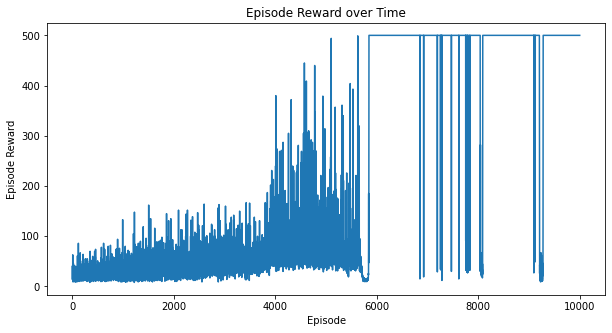

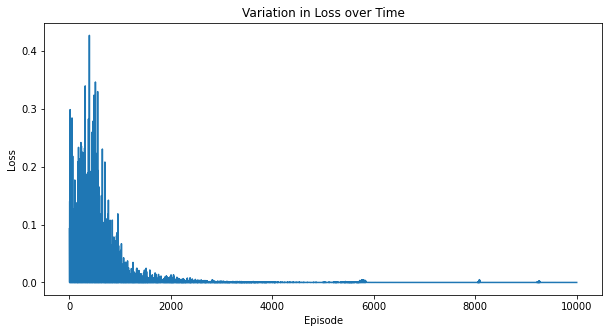

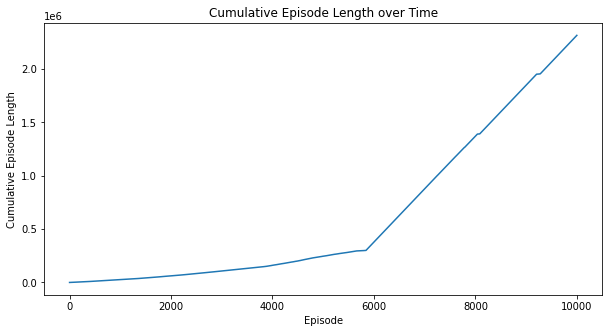

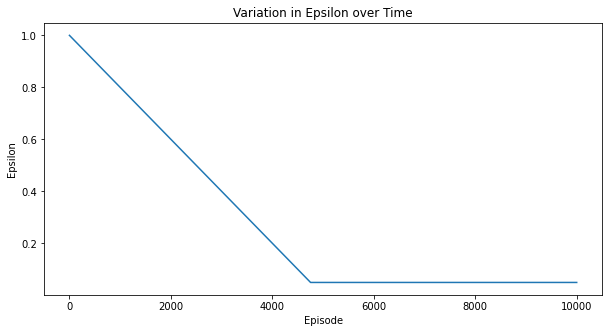

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
# Plot for agent with high training 
plot_dqnresults(losses_list,reward_list,episode_len_list,epsilon_list)

In [ ]:
# Agent Trained for a small amount of time
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256
agent = DQN_Agent(seed=1423, layer_sizes=[input_dim, 64, output_dim], lr=1e-3, sync_freq=5,
                  exp_replay_size=exp_replay_size)

# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list = [], [], [], []
episodes = 10
epsilon = 1

# initiliaze experiance replay
index = 0
for i in range(exp_replay_size):
    obs = env.reset()
    done = False
    while not done:
        A = agent.get_action(obs, env.action_space.n, epsilon=1)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
        obs = obs_next
        index += 1
        if index > exp_replay_size:
            break

index = 128
for i in tqdm(range(episodes)):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while not done:
        ep_len += 1
        A = agent.get_action(obs, env.action_space.n, epsilon)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])

        obs = obs_next
        rew += reward
        index += 1

        if index > 128:
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=16)
                losses += loss
    if epsilon > 0.05:
        epsilon -= (1 / 5000)

    losses_list.append(losses / ep_len), 
    reward_list.append(rew)
    episode_len_list.append(ep_len), 
    epsilon_list.append(epsilon)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
100%|██████████| 10/10 [00:00<00:00, 125.9

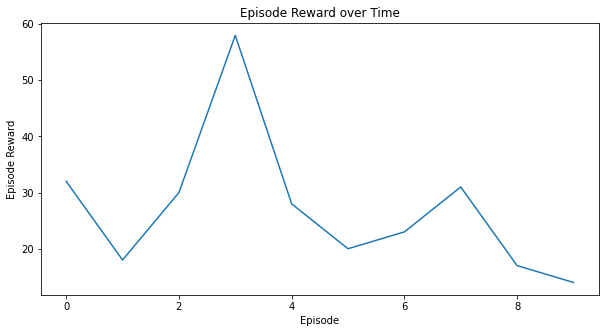

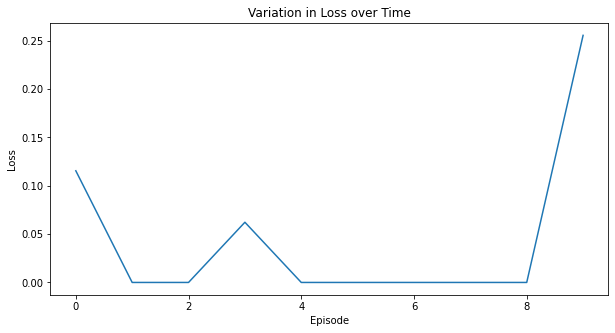

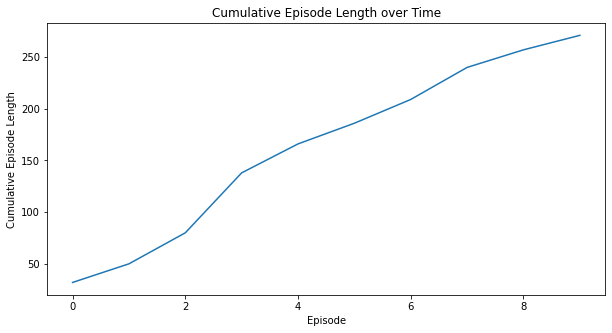

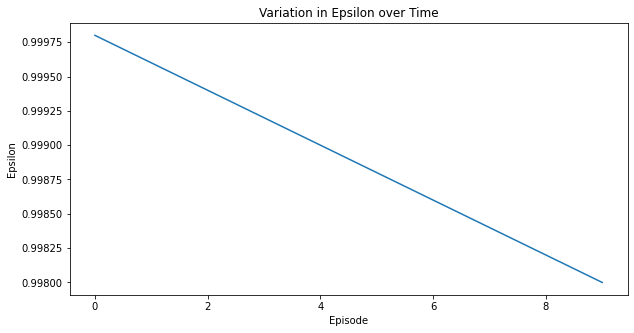

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
# Plot for agent with low training 
plot_dqnresults(losses_list,reward_list,episode_len_list,epsilon_list)

In [ ]:
# Random Agent
from torch import randint
import gym

losses_list, reward_list, episode_len_list, epsilon_list = [], [], [], []
epsilon = 1
episode_count = 100
env = gym.make('CartPole-v1')

for i in range(episode_count):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while done != True:
        A = randint(0, env.action_space.n, (1,))
        obs, reward, done, info = env.step(A.item())
        rew += reward
        ep_len += 1

    if epsilon > 0.05:
        epsilon -= (1 / 5000)

    reward_list.append(rew)
    episode_len_list.append(ep_len), 
    epsilon_list.append(epsilon)


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


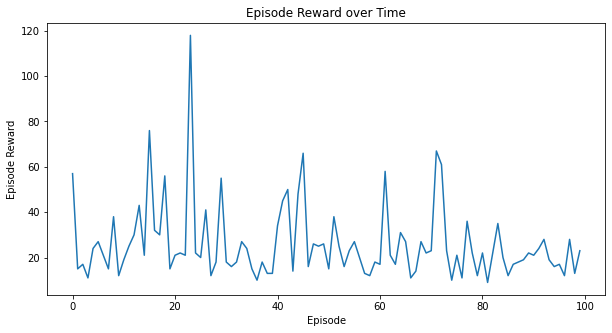

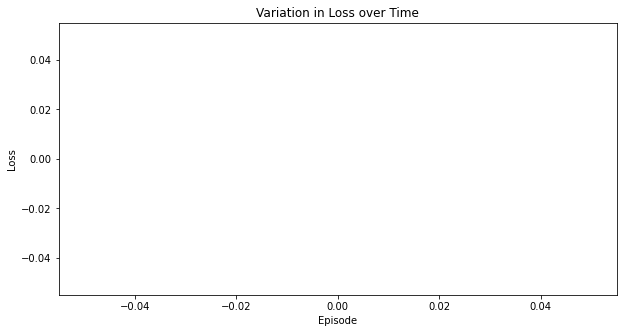

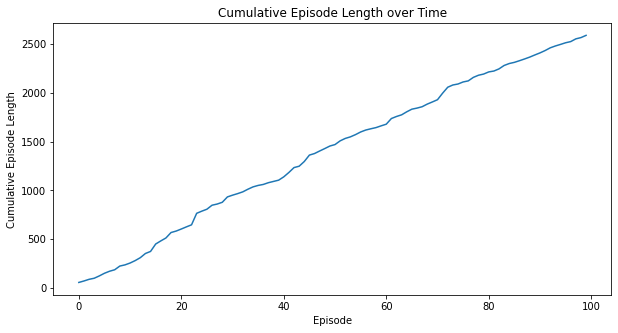

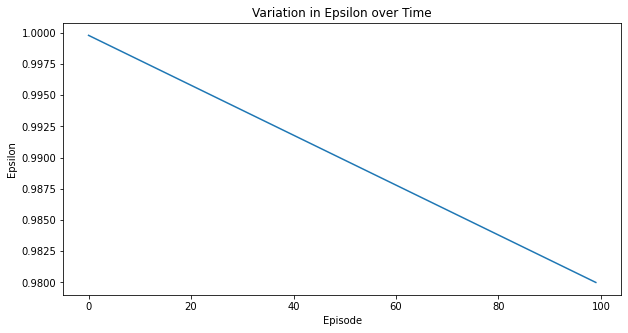

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
# Plot for random agent 
plot_dqnresults(losses_list,reward_list,episode_len_list,epsilon_list)